# Purposes of this document

the goal of this jupyter is to a trained Kalman filter
and look at the behaviour results

note all of this is in the branch sijia as of 2021 Jan


# setting up the simulation components

this section largely copyied and pasted from   
bmi3d-sijia(branch)-bulti_in_experiemnts
https://github.com/sijia66/brain-python-interface/blob/master/built_in_tasks/sim_task_KF.py

In [1]:
# import libraries
# make sure these directories are in the python path., 
from bmimultitasks import SimBMIControlMulti, SimBMICosEncKFDec, BMIControlMultiNoWindow
from features import SaveHDF
from features.simulation_features import get_enc_setup, SimKFDecoderRandom, SimCosineTunedEnc,SimIntentionLQRController, SimClockTick
from features.simulation_features import SimHDF, SimTime

from riglib import experiment

from riglib.stereo_opengl.window import FakeWindow

import time
import copy
import numpy as np

/home/sijia-aw/BMi3D_my/lab_bmi3d/riglib/blackrock/cerelink.py:13: UserWarning: Unable to import cerebus library. Check if is installed if using the Blackrock NeuroPort system
  warnings.warn("Unable to import cerebus library. Check if is installed if using the Blackrock NeuroPort system")


##  set up trial information

In [2]:
#generate task params
N_TARGETS = 8
N_TRIALS = 8
seq = SimBMIControlMulti.sim_target_seq_generator_multi(
N_TARGETS, N_TRIALS)

##  simulation encoder decoder setup

In [3]:
#clda on random 
DECODER_MODE = 'trainedKF' # in this case we load simulation_features.SimKFDecoderRandom
ENCODER_TYPE = 'cosine_tuned_encoder'
LEARNER_TYPE = 'dumb' # to dumb or not dumb it is a question 'feedback'
UPDATER_TYPE = 'none' #none or "smooth_batch"


SAVE_HDF = False

SAVE_SIM_HDF = True #this makes the task data available as exp.task_data_hist

DEBUG_FEATURE = False

#neuron set up : 'std (20 neurons)' or 'toy (4 neurons)' 
N_NEURONS, N_STATES, sim_C = get_enc_setup(sim_mode = 'toy')

features.simulation_features: get_enc_setup has a tuning_level of 1 



## from the setup options, set up experiment

In [4]:
# set up assist level
assist_level = (0, 0)

#base_class = SimBMIControlMulti
base_class = BMIControlMultiNoWindow
feats = []

#set up intention feedbackcontroller
#this ideally set before the encoder
feats.append(SimIntentionLQRController)

#set up the encoder
if ENCODER_TYPE == 'cosine_tuned_encoder' :
    feats.append(SimCosineTunedEnc)
    print(f'{__name__}: selected SimCosineTunedEnc\n')
    
    
   #take care the decoder setup
if DECODER_MODE == 'random':
    feats.append(SimKFDecoderRandom)
    print(f'{__name__}: set base class ')
    print(f'{__name__}: selected SimKFDecoderRandom \n')
else: #defaul to a cosEnc and a pre-traind KF DEC
    from features.simulation_features import SimKFDecoderSup
    feats.append(SimKFDecoderSup)
    print(f'{__name__}: set decoder to SimKFDecoderSup\n')
    
    
#you know what? 
#learner only collects firing rates labeled with estimated estimates
#we would also need to use the labeled data
#now, we can set up a dumb/or not-dumb learner
if LEARNER_TYPE == 'feedback':
    from features.simulation_features import SimFeedbackLearner
    feats.append(SimFeedbackLearner)
else:
    from features.simulation_features import SimDumbLearner
    feats.append(SimDumbLearner)




#to update the decoder.
if UPDATER_TYPE == 'smooth_batch':
    from features.simulation_features import SimSmoothBatch
    feats.append(SimSmoothBatch)
else: #defaut to none 
    print(f'{__name__}: need to specify an updater')
    
if DEBUG_FEATURE: 
    from features.simulation_features import DebugFeature
    feats.append(DebugFeature)
    
if SAVE_HDF: feats.append(SaveHDF)
if SAVE_SIM_HDF: feats.append(SimHDF)
    
    
#pass the real time limit on clock
feats.append(SimClockTick)
feats.append(SimTime)


#save everthing in a kw
kwargs = dict()
kwargs['sim_C'] = sim_C

__main__: selected SimCosineTunedEnc

__main__: set decoder to SimKFDecoderSup

__main__: need to specify an updater


## seed the exp

In [5]:
np.random.seed(0)

## make our experiment class

In [6]:
#spawn the task
Exp = experiment.make(base_class, feats=feats)
#print(Exp)
exp = Exp(seq, **kwargs)
exp.init()

metaclass constructor
(<class 'features.simulation_features.SimIntentionLQRController'>, <class 'features.simulation_features.SimCosineTunedEnc'>, <class 'features.simulation_features.SimKFDecoderSup'>, <class 'features.simulation_features.SimDumbLearner'>, <class 'features.simulation_features.SimHDF'>, <class 'features.simulation_features.SimClockTick'>, <class 'features.simulation_features.SimTime'>, <class 'bmimultitasks.BMIControlMultiNoWindow'>)
[<class 'features.simulation_features.SimIntentionLQRController'>, <class 'features.simulation_features.SimCosineTunedEnc'>, <class 'features.simulation_features.SimKFDecoderSup'>, <class 'features.simulation_features.SimDumbLearner'>, <class 'features.simulation_features.SimHDF'>, <class 'features.simulation_features.SimClockTick'>, <class 'features.simulation_features.SimTime'>]

features.simulation_features.SimIntentionLQRController: LQRController used 

0.0
0.0
finished executing Experiment.__init__

SimCosineTunedEnc SSM: State space:

## test run a bit

print(exp.state)
exp.run() 

# now comes to the step through BMIloop


## decode neural features to move cursor
this section basically steps through the move_plant stuff

@riglib.bmi.BMILoop.move_plant

# assemble into a complete loop

In [7]:
# riglib.experiment: line 597 - 601
#exp.next_trial = next(exp.gen)
# -+exp._parse_next_trial()


# we need to set the initial state
# per fsm.run:  line 138


# Initialize the FSM before the loop
exp.set_state(exp.state)


while exp.state is not None:

    # exp.fsm_tick()

    ### Execute commands#####
    exp.exec_state_specific_actions(exp.state)

    ###run the bmi loop #####
    # _cycle

    # bmi feature extraction, eh
    #riglib.bmi: 1202
    feature_data = exp.get_features()

    # Determine the target_state and save to file
    current_assist_level = exp.get_current_assist_level()
    '''
        if np.any(current_assist_level > 0) or exp.learn_flag:
        target_state = exp.get_target_BMI_state(exp.decoder.states)
    else:
        target_state = np.ones(
            [exp.decoder.n_states, exp.decoder.n_subbins]) * np.nan
    
    '''
    target_state = exp.get_target_BMI_state(exp.decoder.states)


    # decode the new features
    # riglib.bmi.bmiloop: line 1245
    neural_features = feature_data[exp.extractor.feature_type]

    # call decoder.
    #tmp = exp.call_decoder(neural_features, target_state, **kwargs)
    neural_obs = neural_features
    learn_flag = exp.learn_flag
    task_state = exp.state

    n_units, n_obs = neural_obs.shape
    # If the target is specified as a 1D position, tile to match
    # the number of dimensions as the neural features
    if np.ndim(target_state) == 1 or (target_state.shape[1] == 1 and n_obs > 1):
        target_state = np.tile(target_state, [1, n_obs])

    decoded_states = np.zeros([exp.bmi_system.decoder.n_states, n_obs])
    update_flag = False

    for k in range(n_obs):
        neural_obs_k = neural_obs[:, k].reshape(-1, 1)
        target_state_k = target_state[:, k]

        # NOTE: the conditional below is *only* for compatibility with older Carmena
        # lab data collected using a different MATLAB-based system. In all python cases,
        # the task_state should never contain NaN values.
        if np.any(np.isnan(target_state_k)):
            task_state = 'no_target'

        #################################
        # Decode the current observation
        #################################
        decodable_obs, decode = exp.bmi_system.feature_accumulator(
            neural_obs_k)
        if decode:  # if a new decodable observation is available from the feature accumulator
            prev_state = exp.bmi_system.decoder.get_state()

            exp.bmi_system.decoder(decodable_obs, **kwargs)
            # Determine whether the current state or previous state should be given to the learner
            if exp.bmi_system.learner.input_state_index == 0:
                learner_state = exp.bmi_system.decoder.get_state()
            elif exp.bmi_system.learner.input_state_index == -1:
                learner_state = prev_state
            else:
                print(("Not implemented yet: %d" %
                       exp.bmi_system.learner.input_state_index))
                learner_state = prev_state

            if learn_flag:
                exp.bmi_system.learner(decodable_obs.copy(), learner_state, target_state_k, exp.bmi_system.decoder.get_state(
                ), task_state, state_order=exp.bmi_system.decoder.ssm.state_order)

        decoded_states[:, k] = exp.bmi_system.decoder.get_state()

        ############################
        # Update decoder parameters
        ############################
        if exp.bmi_system.learner.is_ready():
            batch_data = exp.bmi_system.learner.get_batch()
            batch_data['decoder'] = exp.bmi_system.decoder
            kwargs.update(batch_data)
            exp.bmi_system.updater(**kwargs)
            exp.bmi_system.learner.disable()

        new_params = None  # by default, no new parameters are available
        if exp.bmi_system.has_updater:
            new_params = copy.deepcopy(exp.bmi_system.updater.get_result())

        # Update the decoder if new parameters are available
        if not (new_params is None):
            exp.bmi_system.decoder.update_params(
                new_params, **exp.bmi_system.updater.update_kwargs)
            new_params['intended_kin'] = batch_data['intended_kin']
            new_params['spike_counts_batch'] = batch_data['spike_counts']

            exp.bmi_system.learner.enable()
            update_flag = True

            # Save new parameters to parameter history
            exp.bmi_system.param_hist.append(new_params)
            
    

    # saved as task data
    # return decoded_states, update_flag
    tmp = decoded_states
    exp.task_data['internal_decoder_state'] = tmp

    # reset the plant position
    # @riglib.bmi.BMILoop.move_plant  line:1254
    exp.plant.drive(exp.decoder)

    # check state transitions and run the FSM.
    current_state = exp.state

    # iterate over the possible events which could move the task out of the current state
    for event in exp.status[current_state]:
        # if the event has occurred
        if exp.test_state_transition_event(event):
            # execute commands to end the current state
            exp.end_state(current_state)

            # trigger the transition for the event
            exp.trigger_event(event)

            # stop searching for transition events (transition events must be
            # mutually exclusive for this FSM to function properly)
            break

    # sort out the loop params.
    # inc cycle count
    exp.cycle_count += 1

    # save target data as was done in manualControlTasks._cycle
    exp.task_data['target'] = exp.target_location.copy()
    exp.task_data['target_index'] = exp.target_index
    
    #done in bmi:_cycle after move_plant
    exp.task_data['loop_time'] = exp.iter_time()
    
    
    #fb_controller data
    exp.task_data['target_state'] = target_state
    
    #encoder data
    #input to this is actually extractor
    exp.task_data['ctrl_input'] = np.reshape(exp.extractor.sim_ctrl, (1,-1))
    
    #actually output
    exp.task_data['spike_counts'] = feature_data['spike_counts']
    
    
    #save the decoder_state
    #from BMILoop.move_plant
    exp.task_data['decoder_state'] = exp.decoder.get_state(shape=(-1,1))
    
    
    # as well as plant data.
    plant_data = exp.plant.get_data_to_save()
    for key in plant_data:
        exp.task_data[key] = plant_data[key]

    # clda data handled in the above call.

    # save to the list hisory of data.
    exp.task_data_hist.append(exp.task_data.copy())


if exp.verbose:
    print("end of FSM.run, task state is", exp.state)

0.0
runseq
0.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
2.0
2.0
2.0
2.0
2.0
3.0
3.0
3.0
3.0
3.0
4.0
4.0
4.0
4.0
4.0
end of FSM.run, task state is None


# Preprocess the data for loading

In [8]:
import  matplotlib.pyplot as plt

In [9]:
task_data_hist_np = np.array(exp.task_data_hist)


In [10]:
task_data_hist_np.dtype

dtype([('cursor', '<f8', (3,)), ('loop_time', '<f8', (1,)), ('decoder_state', '<f8', (7, 1)), ('internal_decoder_state', '<f8', (7, 1)), ('target_state', '<f8', (7, 1)), ('update_bmi', '<f8', (1,)), ('spike_counts', '<f8', (4, 1)), ('bin_edges', '<f8', (2,)), ('ctrl_input', '<f8', (7,)), ('assist_level', '<f8', (1,)), ('target', '<f8', (3,)), ('target_index', '<i4', (1,))])

In [11]:
cursor_trajectory = np.squeeze(task_data_hist_np['cursor'])

In [12]:
cursor_trajectory.shape

(2422, 3)

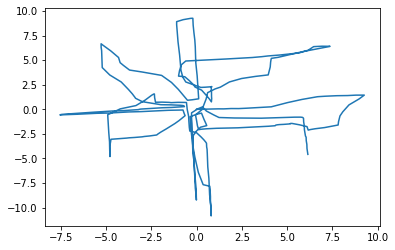

In [13]:
plt.plot(cursor_trajectory[:,0], cursor_trajectory[:,2])

In [14]:
exp.calc_state_occurrences('reward')

8

# Walk through loop

## this system starts from feedback_controller

feedback controller generates ctrl input matrix   
from the difference between the target state and the and current state

In [15]:
exp.fb_ctrl.A

matrix([[1. , 0. , 0. , 0.1, 0. , 0. , 0. ],
        [0. , 1. , 0. , 0. , 0.1, 0. , 0. ],
        [0. , 0. , 1. , 0. , 0. , 0.1, 0. ],
        [0. , 0. , 0. , 0.8, 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0.8, 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0.8, 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 1. ]])

In [16]:
exp.fb_ctrl.B

matrix([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [100.,   0.,   0.],
        [  0., 100.,   0.],
        [  0.,   0., 100.],
        [  0.,   0.,   0.]])

In [17]:
exp.fb_ctrl.F

matrix([[0.00860175, 0.        , 0.        , 0.00294097, 0.        ,
         0.        , 0.        ],
        [0.        , 0.00860175, 0.        , 0.        , 0.00294097,
         0.        , 0.        ],
        [0.        , 0.        , 0.00860175, 0.        , 0.        ,
         0.00294097, 0.        ]])

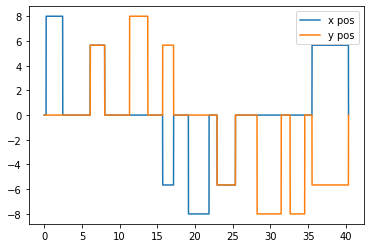

In [44]:
target_state = np.squeeze(task_data_hist_np['target_state'])
time_vec = np.arange(target_state.shape[0])/60 # 60 Hz
plt.plot(time_vec,target_state[:,(0,2)])
plt.legend(('x pos', 'y pos'))


## and encoder

In [ ]:
# encoder matrix.
exp.encoder.C

In [ ]:
exp.encoder.call_count

In [ ]:
spike_counts = np.squeeze(task_data_hist_np['spike_counts'])
plt.plot(spike_counts)

## decoder stuff

In [ ]:
exp.decoder.call_rate

In [ ]:
exp.decoder.filt

In [ ]:
target_state = np.squeeze(task_data_hist_np['decoder_state'])
plt.plot(target_state[:,5])

In [ ]:
task_data_hist_np.dtype

# summarize the behaviour

In [ ]:
state_log = exp.state_log

In [ ]:
def filter_state(state_log:list, state_to_match:str)->list:
    '''
    state_log: a list of tuples (state:string, start_time: float)
    state_to_watch
    
    returns a list of element type
    '''
    
    
    return list(filter(lambda k: k[0] == state_to_match, state_log) )

def calc_inter_wait_times(wait_log: list)-> list:
    """
    state_log: a list of tuples ("wait", start_time: float)
    return a list of tuples: ("wait", start_time: float, diff_time)
    """
    wait_log_with_diff = list()
    for i, wait_state in enumerate(wait_log):
        if i == 0: #there is nothing to subtract, just put zero.
            wait_log_with_diff.append((wait_state[0], wait_state[1], 0))
        else:
            previous_time = wait_log[i-1][1]
            wait_log_with_diff.append((wait_state[0], wait_state[1],  wait_state[1]- previous_time))
    
    return wait_log_with_diff
    
    
    

wait_seq = filter_state(state_log, 'wait')
wait_seq_diff = np.array(calc_inter_wait_times(wait_seq))
plt.scatter(wait_seq_diff[:,1], 
           wait_seq_diff[:,2])

this is just wrong


# the KF tracks the state as steered by control input

In [ ]:
# inputs to the encoder
encoder_ctrl_input = np.squeeze(task_data_hist_np['ctrl_input'])
#plt.plot(encoder_ctrl_input)
encoder_ctrl_input.shape

In [ ]:
target_state = np.squeeze(task_data_hist_np['decoder_state'])
target_state.shape

In [ ]:
# we compare the x_vel 
X_VEL_STATE_IND = 3

enc_ctrl_dec_state =  np.vstack((encoder_ctrl_input[:, X_VEL_STATE_IND], 
                                      target_state[:, X_VEL_STATE_IND]))

enc_ctrl_dec_state = enc_ctrl_dec_state.T #want a vertifcal vec with col as var
enc_ctrl_dec_state.shape

In [ ]:
FRAME_RATE = 60
time_axis = np.arange(encoder_ctrl_input.shape[0] ) / FRAME_RATE
plt.plot(time_axis, encoder_ctrl_input[:, X_VEL_STATE_IND] ,label = 'ctrl_input x vel')
plt.plot(time_axis, target_state[:, X_VEL_STATE_IND],label = 'KF decoder tracked x vel')
plt.legend()

plt.xlabel('time (s)')
plt.ylabel('X vel')
plt.title('Tracking X ctrl input with KF decoder')
plt.show()



tracked well 
suspect towards end of the plot
the short smooth batch size worsens the tracking

In [ ]:
state_indices = [0,2,3,5]
state_names = ['x pos ', 'z pos', 'x vel', 'z vel']

time_axis = np.arange(encoder_ctrl_input.shape[0] ) / FRAME_RATE

## now we can plot
#enc_state_axes = plt.subplots(2,2)

time_axis = np.arange(encoder_ctrl_input.shape[0] ) / FRAME_RATE

for i, state_ind in enumerate(state_indices):
    plt.subplot(2,2,i+1)
    plt.title(f'Compare{state_names[i]}')
    plt.plot(time_axis, encoder_ctrl_input[:, state_ind] ,label = 'ctrl_input')
    plt.plot(time_axis, target_state[:, state_ind],label = 'KF decoder tracked')  
    

    plt.xlabel('time (s)')
    plt.ylabel(f'{state_names[i]}')

    
plt.legend()


In [ ]:
#quantify the corr


state_indices = [0,2,3,5]
enc_dec_corr =list()

for i, state_ind in enumerate(state_indices):
    enc_dec_corr.append(np.corrcoef(encoder_ctrl_input[:, state_ind], 
                              target_state[:, state_ind],
                              rowvar=False)[0,1])
enc_dec_corr

the tracking of the 2D velocities measured by corr_coeff is not perfect:

these are time shifts introduced by state_space model
the almost perfect position tracking might be an illusion  
1. because the control inputs do not change positions 
2. as we are dealing with a velocity kalman filter.